# Título

## Contexto

In [107]:
# pip install folium

## Análise descritiva

In [2]:
# Bibliotecas

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import folium


In [3]:
# Carregando o arquivo csv

dados_df = pd.read_csv("/home/rosana/Documents/Processo_seletivo_Fintec( Estagio em ciencia de dados)/dataset_2022.csv")
dados_df;

In [4]:
# Alterando a primeira letra do nome de cada coluna.

dados_df.columns = dados_df.columns.str.strip().str.capitalize() 
dados_df

,Data,Latitude,Longitude,Tipo
0,2022-01-01 16:55:56-03:00,-20.326783,-45.989391,0
1,2022-01-01 16:55:56-03:00,-20.322183,-45.987291,0
2,2022-01-01 16:55:56.985000-03:00,-20.337263,-45.975291,1
3,2022-01-01 16:55:56.997000-03:00,-20.334103,-45.985891,0
4,2022-01-01 16:55:57-03:00,-20.333383,-46.018591,0
...,...,...,...,...
220696,2022-12-31 21:14:53.433000-03:00,-19.867303,-45.706591,1
220697,2022-12-31 21:14:53.455790-03:00,-19.898383,-45.744691,1
220698,2022-12-31 21:17:14.225225-03:00,-19.898783,-45.743891,1
220699,2022-12-31 21:19:20.140002-03:00,-19.850383,-45.746191,1


In [5]:
df = dados_df
df['Data']

0                2022-01-01 16:55:56-03:00
1                2022-01-01 16:55:56-03:00
2         2022-01-01 16:55:56.985000-03:00
3         2022-01-01 16:55:56.997000-03:00
4                2022-01-01 16:55:57-03:00
                        ...               
220696    2022-12-31 21:14:53.433000-03:00
220697    2022-12-31 21:14:53.455790-03:00
220698    2022-12-31 21:17:14.225225-03:00
220699    2022-12-31 21:19:20.140002-03:00
220700    2022-12-31 21:21:54.263374-03:00
Name: Data, Length: 220701, dtype: object

In [6]:
# Alterando o formato da coluna Data para data e hora.

df['Data'] = pd.to_datetime(df['Data']) 
df['Data'] 

0               2022-01-01 16:55:56-03:00
1               2022-01-01 16:55:56-03:00
2        2022-01-01 16:55:56.985000-03:00
3        2022-01-01 16:55:56.997000-03:00
4               2022-01-01 16:55:57-03:00
                       ...               
220696   2022-12-31 21:14:53.433000-03:00
220697   2022-12-31 21:14:53.455790-03:00
220698   2022-12-31 21:17:14.225225-03:00
220699   2022-12-31 21:19:20.140002-03:00
220700   2022-12-31 21:21:54.263374-03:00
Name: Data, Length: 220701, dtype: datetime64[ns, pytz.FixedOffset(-180)]

In [7]:
# Extraindo dia, mês, ano e hora da coluna Data

df['Dia'] = df['Data'].dt.day
df['Mes'] = df['Data'].dt.month
df['Ano'] = df['Data'].dt.year
df['Hora'] = df['Data'].dt.hour
df

,Data,Latitude,Longitude,Tipo,Dia,Mes,Ano,Hora
0,2022-01-01 16:55:56-03:00,-20.326783,-45.989391,0,1,1,2022,16
1,2022-01-01 16:55:56-03:00,-20.322183,-45.987291,0,1,1,2022,16
2,2022-01-01 16:55:56.985000-03:00,-20.337263,-45.975291,1,1,1,2022,16
3,2022-01-01 16:55:56.997000-03:00,-20.334103,-45.985891,0,1,1,2022,16
4,2022-01-01 16:55:57-03:00,-20.333383,-46.018591,0,1,1,2022,16
...,...,...,...,...,...,...,...,...
220696,2022-12-31 21:14:53.433000-03:00,-19.867303,-45.706591,1,31,12,2022,21
220697,2022-12-31 21:14:53.455790-03:00,-19.898383,-45.744691,1,31,12,2022,21
220698,2022-12-31 21:17:14.225225-03:00,-19.898783,-45.743891,1,31,12,2022,21
220699,2022-12-31 21:19:20.140002-03:00,-19.850383,-45.746191,1,31,12,2022,21


In [ ]:
# Mudando o tipo das colunas Latitude e longitude para String

df['Latitude_Str'] = df['Latitude'].astype('string')
df['Longitude_Str'] = df['Longitude'].astype('string')

In [24]:
# Concatenando as duas colunas para conseguir os pares exatos

df['Lati_Longi'] = df['Latitude_Str'].str.cat(df['Longitude_Str'], sep= ' ')
df['Lati_Longi']

0           -20.32678314110823 -45.98939118851705
1           -20.32218314110823 -45.98729118851705
2          -20.337263141108227 -45.97529118851705
3           -20.33410314110823 -45.98589118851705
4           -20.33338314110823 -46.01859118851705
                           ...                   
220696     -19.86730314110823 -45.706591188517045
220697     -19.89838314110823 -45.744691188517045
220698      -19.89878314110823 -45.74389118851705
220699    -19.850383141108228 -45.746191188517045
220700     -19.86658314110823 -45.770191188517046
Name: Lati_Longi, Length: 220701, dtype: string

In [35]:
# Filtrando valores por mês

Janeiro = df.query('Mes == 1')

Fevereiro = df.query('Mes == 2')


In [42]:
# Verificando valores unicos na coluna Lati_Longi

Janeiro['Lati_Longi'].unique()
Fevereiro['Lati_Longi'].unique()

<StringArray>
[ '-19.76708314110823 -46.16899118851705',
 '-19.764183141108223 -46.19089118851705',
 '-19.76388314110823 -46.233791188517046',
 '-19.763683141108228 -46.19219118851705',
 '-19.741283141108227 -46.20669118851705',
  '-19.76288314110823 -46.23049118851705',
 '-19.763583141108228 -46.23939118851705',
 '-19.763483141108228 -46.21209118851705',
  '-19.75058314110823 -46.24829118851705',
 '-19.740223141108228 -46.08669118851705',
 ...
 '-20.06068314110823 -46.279991188517045',
 '-19.99958314110823 -46.297991188517045',
  '-20.05668314110823 -46.29569118851705',
 '-19.999883141108228 -46.30639118851705',
 '-20.004983141108227 -46.30709118851705',
 '-19.994823141108228 -46.32009118851705',
 '-19.99844314110823 -46.331591188517045',
 '-19.992483141108227 -46.36409118851705',
  '-20.05718314110823 -46.28909118851705',
 '-20.06208314110823 -46.274891188517046']
Length: 14221, dtype: string

KeyError: 'Mes'

In [49]:
Fevereiro['Latitude'].shape

(14961,)

### Dados inconsistentes

A coluna Tipo foi verificada com o obrjtivo de verificar se havia mais tipos de descarga nuvem-solo(0) ou intranuvem (1), contudo, contando os valores havia um registro diferente do esperado para essa coluna, o valor 40. 

In [8]:
# Agrupando os dados de acordo com o tipo.

df.groupby(['Tipo']).count() 

,Data,Latitude,Longitude,Dia,Mes,Ano,Hora
Tipo,,,,,,,
0,78407,78407,78407,78407,78407,78407,78407
1,142180,142180,142180,142180,142180,142180,142180
40,114,114,114,114,114,114,114


In [9]:
# filtrando valor inconsistente

valor_inconsistente = df['Tipo'] == 40
#valor_inconsistente.describe()
df_filtrado = df[valor_inconsistente]


Os valores inconsistentes não podem ser apagados do nosso dataframe sem antes serem analisados, sendo assim, é necessário uma investigação mais profunda.

In [10]:
# Em quais meses esse erro ocorreu? Existe algum padrão?

df_filtrado['Mes']

51833      8
56789      8
57885      8
71024      9
72412      9
          ..
219356    12
219386    12
219792    12
220072    12
220547    12
Name: Mes, Length: 114, dtype: int64

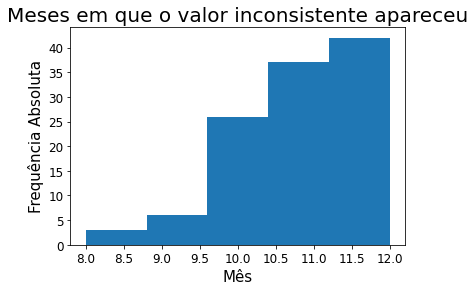

In [11]:
# Histograma 

plt.hist(df_filtrado['Mes'],5, rwidth=1)
plt.title('Meses em que o valor inconsistente apareceu', fontsize = 20)
plt.xlabel('Mês',fontsize = 15)
plt.ylabel('Frequência Absoluta', fontsize = 15)
plt.tick_params(labelsize = 12)


Foi de agosto a dezembro que esses registros apareceram.

In [14]:
#df_filtrado['f_latitude'] = 
df_filtrado['Latitude'].astype('string')

51833     -19.742283141108228
56789     -19.971083141108227
57885      -20.05818314110823
71024      -20.30148314110823
72412     -20.175283141108228
                 ...         
219356     -19.73418314110823
219386     -19.91428314110823
219792     -20.01878314110823
220072     -20.24038314110823
220547    -20.227083141108228
Name: Latitude, Length: 114, dtype: string

In [16]:
df_filtrado['Latitude']

51833    -19.742283
56789    -19.971083
57885    -20.058183
71024    -20.301483
72412    -20.175283
            ...    
219356   -19.734183
219386   -19.914283
219792   -20.018783
220072   -20.240383
220547   -20.227083
Name: Latitude, Length: 114, dtype: float64

In [ ]:
df_filtrado['Latitude']

51833    -19.742283
56789    -19.971083
57885    -20.058183
71024    -20.301483
72412    -20.175283
            ...    
219356   -19.734183
219386   -19.914283
219792   -20.018783
220072   -20.240383
220547   -20.227083
Name: Latitude, Length: 114, dtype: float64

## Mapa

In [ ]:
folium.Map(location = [-20.326783,-45.989391], zoom_start = 9)
